In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import ipyleaflet
import json
import os 

%matplotlib inline

In [203]:
# Load mining site masks.

mining_site_masks = gpd.read_file(os.path.expanduser("~/Desktop/datakind/qgis/mining_masks.shp"))
mining_site_masks = mining_site_masks.iloc[0:1]
mining_site_masks.head()

,pcode,geometry
0,codmine00064,"POLYGON ((29.05845782923338 1.148264452652914,..."


In [211]:
# Load IPIS mining site locations

mining_site_locations = gpd.read_file(os.path.expanduser(
    "~/Desktop/datakind/data/ipis_last_visit/cod_mines_curated_lastvisit_opendata_p_ipis.shp"))

# Select only mining site locations that have been labeled.
mining_site_locations = mining_site_locations[mining_site_locations.pcode.isin(mining_site_masks.pcode)]

# To keep plotting easy, make a small ball around each mining site location.
# mining_site_locations["geometry"] = mining_site_locations.geometry.buffer(1e-4)

mining_site_locations.head()

,vid,pcode,name,visit_date,longitude,latitude,province,province_o,territoire,collectivi,...,final_des1,armed_grou,frequency_,armed_gro0,frequency0,is_3t_mine,is_gold_mi,presence,interferen,geometry
62,1683.0,codmine00064,Mabukulu,2015-06-18,29.05885,1.14835,Ituri,Orientale,Mambasa,Babila-Bakwanza,...,None,FARDC,Une fois par mois,None,None,0,1,1,1.0,POINT (29.05885 1.14835)


In [212]:
# Visualize mining masks.

def get_center(geodataframe):
    """Get a point at the center of a geodataframe's geometry."""
    center = geodataframe.unary_union.convex_hull.centroid
    latitude = center.y
    longitude = center.x
    return (latitude, longitude)

def get_layer(geo_dataframe, color="blue", alpha=0.5):
    """Constructs a Layer based on a GeoDataFrame's geometry."""
    return ipyleaflet.GeoJSON(data=json.loads(geo_dataframe.to_json()), 
                              style={"color": color, "alpha": 0.5})

def satellite_tiles():
    """Constructs a TileLayer with using satellite imagery."""
    return ipyleaflet.TileLayer(
        url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}')

# Construct a map.
leaflet_map = ipyleaflet.Map(center=get_center(mining_site_masks), 
                             zoom=6, 
                             default_tiles=satellite_tiles())

# Add mining site locations and their accompanying masks.
leaflet_map.add_layer(get_layer(mining_site_locations, color="red", alpha=1.0))
leaflet_map.add_layer(get_layer(mining_site_masks, color="blue"))

# Add the ability to draw polygons?
def print_polygon(self, action, geo_json):
    print 'self:', self
    print 'action:', action
    print 'geo_json:', geo_json
    
draw_polygon = ipyleaflet.DrawControl(polygons={"shapeOptions": {}})
draw_polygon.on_draw(print_polygon)
leaflet_map.add_control(draw_polygon)

# Plot
leaflet_map

In [213]:
# Get rasterized satellite image around a point.

import ee as earth_engine; earth_engine.Initialize()

# Construct an earth_engine.Image for mining site masks.
point = mining_site_locations.iloc[0].geometry.centroid
point = earth_engine.Geometry.Point((point.x, point.y))
circle = earth_engine.Geometry.buffer(point, 1500)
circle = circle.getInfo()

json.loads(mining_site_locations.to_json())

{u'features': [{u'geometry': {u'coordinates': [29.05885, 1.14835],
    u'type': u'Point'},
   u'id': u'62',
   u'properties': {u'armed_gro0': None,
    u'armed_grou': u'FARDC',
    u'collectivi': u'Babila-Bakwanza',
    u'final_des0': None,
    u'final_des1': None,
    u'final_dest': u'Bunia, Butembo',
    u'frequency0': None,
    u'frequency_': u'Une fois par mois',
    u'groupement': u'Bapwele',
    u'interferen': 1.0,
    u'is_3t_mine': 0,
    u'is_gold_mi': 1,
    u'latitude': 1.14835,
    u'longitude': 29.05885,
    u'mineral1': u'Or',
    u'mineral2': None,
    u'mineral3': None,
    u'name': u'Mabukulu',
    u'pcode': u'codmine00064',
    u'presence': 1,
    u'province': u'Ituri',
    u'province_o': u'Orientale',
    u'selling_p0': None,
    u'selling_p1': None,
    u'selling_po': u'Mayuano',
    u'territoire': u'Mambasa',
    u'vid': 1683.0,
    u'village': u'Mayuano',
    u'visit_date': u'2015-06-18',
    u'workers_nu': 17.0},
   u'type': u'Feature'}],
 u'type': u'FeatureColle

In [189]:
import shapely

def create_earth_engine_buffer(point_as_shapely, buffer_radius_in_meters):
    point_as_geojson = shapely.geometry.mapping(point_as_shapely)
    point_as_earth_engine = earth_engine.Geometry(point_as_geojson)
    buffer_as_earth_engine = earth_engine.Geometry.buffer(
        point_as_earth_engine, buffer_radius_in_meters)
    return buffer_as_earth_engine.getInfo()

print create_earth_engine_buffer(mining_site_locations.iloc[0].geometry, 
                                 buffer_radius_in_meters=10)

print 80 * '-'
 
def create_earth_engine_mask(mask_as_shapely):
    mask_as_geojson = shapely.geometry.mapping(mask_as_shapely)
    mask_as_geometry = earth_engine.Geometry(mask_as_geojson)
    mask_as_feature = earth_engine.Feature(mask_as_geometry, {"label": 1.0})
    mask_as_feature_collection = earth_engine.FeatureCollection([mask_as_feature])
    mask_as_image =  mask_as_feature_collection.reduceToImage(
        properties=["label"],
        reducer=earth_engine.Reducer.first())
    return mask_as_image

print create_earth_engine_mask(mining_site_masks.unary_union)

{u'type': u'Polygon', u'geodesic': True, u'coordinates': [[[29.66032451145233, 1.010898237460782], [29.66032534358469, 1.0108987362217192], [29.66032622029372, 1.0108991508742065], [29.660327133155565, 1.0108994775013975], [29.660328073419205, 1.0108997130251773], [29.660329032087773, 1.0108998552302269], [29.660329999999995, 1.0108999027807053], [29.66033096791221, 1.010899855230227], [29.66033192658081, 1.0108997130251758], [29.660332866844456, 1.0108994775013913], [29.66033377970623, 1.010899150874227], [29.660334656415355, 1.0108987362216941], [29.66033548854769, 1.0108982374607642], [29.660336268085302, 1.010897659316284], [29.660336987494443, 1.0108970072818622], [29.660337639799835, 1.0108962875737812], [29.66033821865628, 1.010895507076239], [29.660338718414717, 1.010894673279684], [29.660339134183758, 1.0108937942099636], [29.660339461882934, 1.0108928783521611], [29.660339698288812, 1.0108919345670893], [29.66033984107182, 1.010890972002435], [29.660339888823327, 1.0108899999

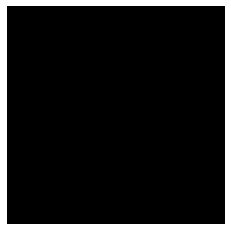

In [185]:
mask = mining.load_map_tile_containing_roi(mask, roi_buffer['coordinates'], 30)
mining.plot_image(mask[:, :, 0])

In [ ]:
earth_engine.